In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Tensorflow Autoencoder (Encoding and decoding images)

In [10]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [11]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0444 - val_loss: 0.0092
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.004

In [14]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

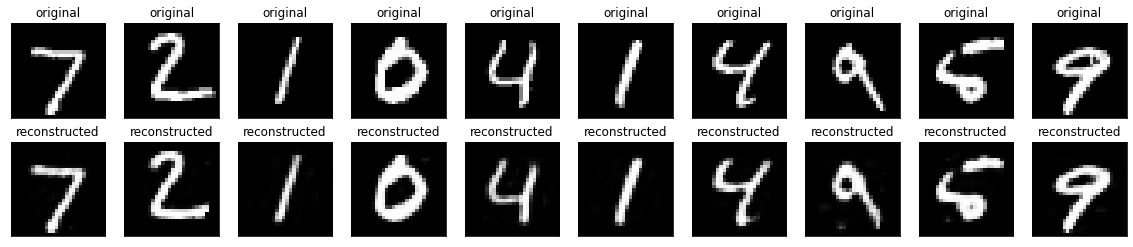

In [15]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Adding noise to denoise images

In [16]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)

(60000, 28, 28, 1)


(60000, 28, 28, 1)

In [26]:
noise_factor = 0.15
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

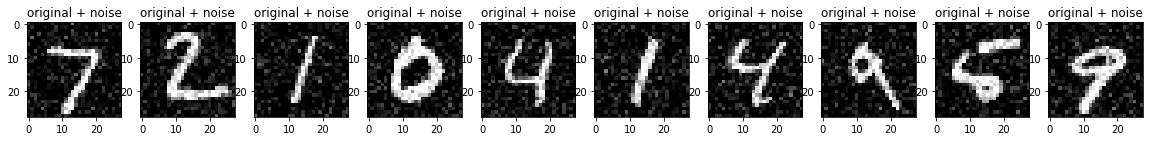

In [27]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [28]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [29]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [30]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0422 - val_loss: 0.0029
Epoch 2/10
1875/1875 [==============================] - 48s 26ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 3/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 4/10
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/10
1875/1875 [==============================] - 53s 28ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 6/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/10
1875/1875 [==============================] - 49s 26m

In [31]:
autoencoder.encoder.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [32]:
autoencoder.decoder.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [33]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

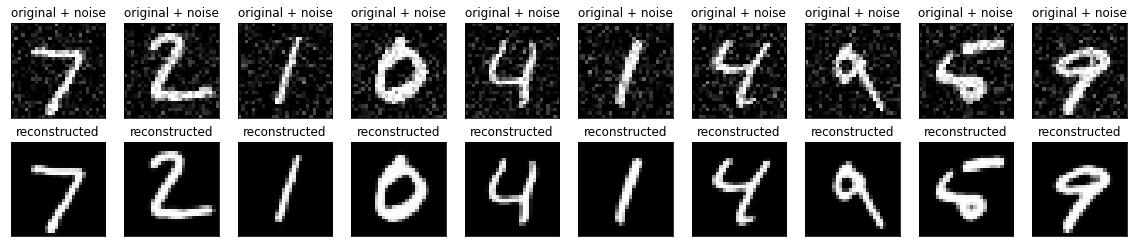

In [34]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
